In [1]:
from google.colab import files
uploaded = files.upload()

Saving VNM.csv to VNM.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import numpy.polynomial.polynomial as poly
import seaborn as sns
from datetime import datetime
from sklearn.utils import column_or_1d
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense, GRU, Dropout

In [3]:
df = pd.read_csv('VNM.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,3/1/2019,"110,654.00","112,611.00","112,611.00","110,654.00",1.04M,0.21%
1,3/4/2019,"111,828.00","110,732.00","112,611.00","110,732.00",1.05M,1.06%
2,3/5/2019,"111,124.00","111,515.00","111,750.00","110,811.00",639.01K,-0.63%
3,3/6/2019,"110,341.00","111,124.00","111,750.00","108,385.00",853.50K,-0.70%
4,3/7/2019,"109,324.00","110,576.00","111,124.00","109,167.00",849.60K,-0.92%
...,...,...,...,...,...,...,...
1310,5/29/2024,"66,300.00","67,000.00","67,300.00","66,000.00",3.36M,-0.75%
1311,5/30/2024,"65,700.00","66,100.00","66,200.00","65,500.00",4.41M,-0.90%
1312,5/31/2024,"65,400.00","65,900.00","65,900.00","65,300.00",4.14M,-0.46%
1313,6/3/2024,"66,100.00","65,800.00","66,600.00","65,700.00",3.19M,1.07%


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1315 entries, 0 to 1314
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1315 non-null   object
 1   Price     1315 non-null   object
 2   Open      1315 non-null   object
 3   High      1315 non-null   object
 4   Low       1315 non-null   object
 5   Vol.      1315 non-null   object
 6   Change %  1315 non-null   object
dtypes: object(7)
memory usage: 72.0+ KB


<h1> Tien xu ly du lieu


In [5]:
df = df.dropna() # Drop missing values
df['Date'] = pd.to_datetime(df['Date'])
df["Price"] = df["Price"].str.replace(',', '').astype(float)

In [6]:
df1 = df.reset_index()['Price']

In [7]:
df['Index'] = np.arange(len(df.index))

<h1> Scale du lieu


In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1>Split the data into training, testing arcording to 7:3

In [9]:
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size

In [10]:
train_data = df1[:train_size]
test_data = df1[train_size:]

<h1> Create dataset


In [11]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [12]:
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [13]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [14]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
#Fit the model
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 97ms/step - loss: 0.2353
Epoch 2/100
13/13 [==============================] - 1s 89ms/step - loss: 0.0275
Epoch 3/100
13/13 [==============================] - 1s 116ms/step - loss: 0.0138
Epoch 4/100
13/13 [==============================] - 1s 61ms/step - loss: 0.0111
Epoch 5/100
13/13 [==============================] - 1s 61ms/step - loss: 0.0075
Epoch 6/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0055
Epoch 7/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0040
Epoch 8/100
13/13 [==============================] - 1s 59ms/step - loss: 0.0029
Epoch 9/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0022
Epoch 10/100
13/13 [==============================] - 1s 51ms/step - loss: 0.0018
Epoch 11/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0016
Epoch 12/100
13/13 [==============================] - 1s 57ms/step - loss: 0.0015
Epoch 13/100
13/13 [====

<h1> Du bao du lieu test

In [16]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 13ms/step


In [17]:
#Chuan hoa du lieu cua y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [18]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[71055.1],
       [71149.9],
       [70580.7],
       [70580.7],
       [70391. ],
       [70675.6],
       [70485.9],
       [70865.3],
       [70580.7],
       [70580.7],
       [70485.9],
       [69726.9],
       [69062.9],
       [68019.3],
       [69252.6],
       [68303.9],
       [68209.1],
       [67260.4],
       [66880.9],
       [66311.7],
       [67355.3],
       [65932.3],
       [66406.6],
       [65078.5],
       [65268.2],
       [66786.1],
       [67070.7],
       [66880.9],
       [66406.6],
       [66027.1],
       [65457.9],
       [66122. ],
       [65457.9],
       [65647.7],
       [65078.5],
       [64699. ],
       [63560.6],
       [62896.5],
       [63655.5],
       [63655.5],
       [63655.5],
       [63086.3],
       [62706.8],
       [62706.8],
       [62517.1],
       [63086.3],
       [62991.4],
       [62801.7],
       [62137.6],
       [62422.2],
       [64414.4],
       [64129.8],
       [63655.5],
       [62896.5],
       [62706.8],
       [62

<h1>
Evaluate the accuracy of the algorithm

In [19]:
#Tính RMSE, MAE, MAPE

test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

#MAE
test_mae = mean_absolute_error(ytest, y_pred)
print('Testing MAE:', test_mae)

#MAPE
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Testing MAPE:', test_mape)

Testing RMSE: 977.7571181350945
Testing MAE: 770.0526174532312
Testing MAPE: 1.1256218559372144


<h1>Du doan co phieu trong 30, 60,90 ngay tiep theo


In [20]:
x_input=test_data[-time_step:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.15134925]
101
1 day input [0.18257135 0.17154416 0.16970474 0.15867756 0.16602964 0.15316303
 0.14948792 0.15684    0.15132548 0.15684    0.16786719 0.17338171
 0.16235267 0.15500059 0.14765037 0.14948792 0.14948792 0.14765037
 0.14948792 0.15867756 0.15684    0.16786719 0.16051511 0.16051511
 0.16051511 0.20462758 0.23954856 0.23219648 0.22852137 0.2340359
 0.22300685 0.22300685 0.24138612 0.24506309 0.24138612 0.23219648
 0.24138612 0.25976724 0.23771101 0.24138612 0.20462758 0.21014211
 0.20462758 0.21933174 0.21381722 0.19892316 0.18216735 0.18030559
 0.1840291  0.19147613 0.18030559 0.1709968  0.17844383 0.17844383
 0.17844383 0.17658207 0.16541153 0.1709968  0.15982626 0.18775262
 0.18216735 0.16541153 0.16541153 0.16168802 0.1579645  0.15982626
 0.12631463 0.10955882 0.11328233 0.11328233 0.10955882 0.10025003
 0.10955882 0.12259112 0.12817639 0.13562342 0.13934693 0.14307045
 0.1840291  0.18216735 0.1579645  0.15610275 0.14307045 0.15610275
 0.16541153 0.16913505 0.16541153 

In [21]:
print(scaler.inverse_transform(lst_output))

[[66244.67667258]
 [66384.21360011]
 [66534.72616054]
 [66687.16123756]
 [66839.94047868]
 [66992.55644195]
 [67144.79942739]
 [67296.56058311]
 [67447.77107629]
 [67598.38688594]
 [67748.37679718]
 [67897.72000008]
 [68046.4012874 ]
 [68194.41665723]
 [68341.75970652]
 [68488.42643335]
 [68634.41523696]
 [68779.73252041]
 [68924.37988446]
 [69068.36453255]
 [69211.69446849]
 [69354.37209342]
 [69496.40461078]
 [69637.80482668]
 [69778.57514225]
 [69918.729164  ]
 [70058.27889763]
 [70197.22754469]
 [70335.59031241]
 [70473.37360385]
 [70610.58702359]
 [70747.24337774]
 [70883.34586782]
 [71018.91130185]
 [71153.94608288]
 [71288.46061586]
 [71422.46450538]
 [71555.96255374]
 [71688.97477046]
 [71821.50035516]
 [71953.55371473]
 [72085.14285296]
 [72216.27417292]
 [72346.9604807 ]
 [72477.20657861]
 [72607.02207122]
 [72736.41496234]
 [72865.39965884]
 [72993.9777615 ]
 [73122.15727411]
 [73249.95260355]
 [73377.3653506 ]
 [73504.40191828]
 [73631.07511272]
 [73757.39133697]
 [73883.35

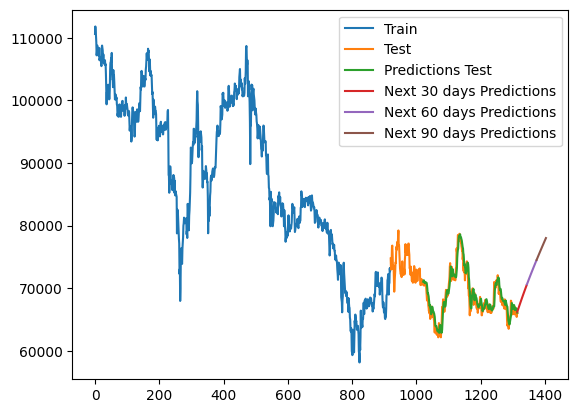

In [22]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + time_step + 1 , stop=len(df1), step=1)
plt.plot(test_data_index, y_pred)

next_30_days_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1) + 29, stop=len(df1) + 59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1) + 59, stop=len(df1) + 89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train', 'Test', 'Predictions Test', 'Next 30 days Predictions', 'Next 60 days Predictions', 'Next 90 days Predictions'])
plt.show()

<h1># Split the data into training, testing arcording to 8:2

In [23]:
train_size = int(0.8 * len(df1))
test_size = len(df1) - train_size

In [24]:
train_data = df1[:train_size]
test_data = df1[train_size:]

<h1>Create dataset

In [25]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [26]:
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [27]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [28]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [29]:
#Fit the model
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 4s 59ms/step - loss: 0.0891
Epoch 2/100
15/15 [==============================] - 1s 60ms/step - loss: 0.0153
Epoch 3/100
15/15 [==============================] - 1s 57ms/step - loss: 0.0070
Epoch 4/100
15/15 [==============================] - 1s 52ms/step - loss: 0.0043
Epoch 5/100
15/15 [==============================] - 1s 89ms/step - loss: 0.0026
Epoch 6/100
15/15 [==============================] - 2s 114ms/step - loss: 0.0017
Epoch 7/100
15/15 [==============================] - 2s 119ms/step - loss: 0.0013
Epoch 8/100
15/15 [==============================] - 2s 157ms/step - loss: 0.0012
Epoch 9/100
15/15 [==============================] - 2s 159ms/step - loss: 0.0012
Epoch 10/100
15/15 [==============================] - 2s 131ms/step - loss: 0.0011
Epoch 11/100
15/15 [==============================] - 1s 95ms/step - loss: 0.0011
Epoch 12/100
15/15 [==============================] - 1s 57ms/step - loss: 0.0011
Epoch 13/100
15/15 [

<h1> Du bao du lieu test

In [30]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

6/6 [==============================] - 0s 13ms/step


In [31]:
#Chuan hoa du lieu cua y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [32]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[72714.1],
       [72224.1],
       [72910.1],
       [72910.1],
       [73988.1],
       [74282.1],
       [73694.1],
       [73302.1],
       [72420.1],
       [69970.2],
       [70852.2],
       [68794.2],
       [68892.2],
       [67618.3],
       [65658.3],
       [66638.3],
       [66246.3],
       [66638.3],
       [68990.2],
       [69480.2],
       [68598.2],
       [69578.2],
       [69382.2],
       [69970.2],
       [69284.2],
       [68206.3],
       [67324.3],
       [67520.3],
       [69284.2],
       [68892.2],
       [68598.2],
       [67912.3],
       [68108.3],
       [68010.3],
       [67324.3],
       [66932.3],
       [66736.3],
       [67128.3],
       [67030.3],
       [66050.3],
       [67030.3],
       [67422.3],
       [66736.3],
       [67128.3],
       [67030.3],
       [67618.3],
       [68598.2],
       [68010.3],
       [66834.3],
       [67030.3],
       [66736.3],
       [65658.3],
       [65658.3],
       [66736.3],
       [66442.3],
       [66

<h1>Evaluate the accuracy of the algorithm




In [33]:
#Tính RMSE, MAE, MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

#MAE
test_mae = mean_absolute_error(ytest, y_pred)
print('Testing MAE:', test_mae)

#MAPE
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Testing MAPE:', test_mape)

Testing RMSE: 826.0634428632366
Testing MAE: 610.9548900462963
Testing MAPE: 0.8999823303695544


<h1>Du doan co phieu trong 30, 60, 90 ngay tiep theo

In [34]:
x_input=test_data[-time_step:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.14819846]
101
1 day input [0.18257135 0.17154416 0.16970474 0.15867756 0.16602964 0.15316303
 0.14948792 0.15684    0.15132548 0.15684    0.16786719 0.17338171
 0.16235267 0.15500059 0.14765037 0.14948792 0.14948792 0.14765037
 0.14948792 0.15867756 0.15684    0.16786719 0.16051511 0.16051511
 0.16051511 0.20462758 0.23954856 0.23219648 0.22852137 0.2340359
 0.22300685 0.22300685 0.24138612 0.24506309 0.24138612 0.23219648
 0.24138612 0.25976724 0.23771101 0.24138612 0.20462758 0.21014211
 0.20462758 0.21933174 0.21381722 0.19892316 0.18216735 0.18030559
 0.1840291  0.19147613 0.18030559 0.1709968  0.17844383 0.17844383
 0.17844383 0.17658207 0.16541153 0.1709968  0.15982626 0.18775262
 0.18216735 0.16541153 0.16541153 0.16168802 0.1579645  0.15982626
 0.12631463 0.10955882 0.11328233 0.11328233 0.10955882 0.10025003
 0.10955882 0.12259112 0.12817639 0.13562342 0.13934693 0.14307045
 0.1840291  0.18216735 0.1579645  0.15610275 0.14307045 0.15610275
 0.16541153 0.16913505 0.16541153 

In [35]:
print(scaler.inverse_transform(lst_output))

[[66075.43918461]
 [66139.79146608]
 [66202.14679546]
 [66263.73535926]
 [66324.71083076]
 [66385.19967025]
 [66445.31473152]
 [66505.14325619]
 [66564.74287171]
 [66624.16320176]
 [66683.43386045]
 [66742.57325656]
 [66801.59579695]
 [66860.51188659]
 [66919.32312624]
 [66978.03751971]
 [67036.65426663]
 [67095.17576814]
 [67153.60282462]
 [67211.93063378]
 [67270.16880021]
 [67328.31012046]
 [67386.35459453]
 [67444.30702472]
 [67502.16420951]
 [67559.92614888]
 [67617.59524398]
 [67675.1722952 ]
 [67732.65169987]
 [67790.04306256]
 [67847.34158098]
 [67904.55125705]
 [67961.67048999]
 [68018.70088058]
 [68075.64162843]
 [68132.49593506]
 [68189.26540125]
 [68245.94842622]
 [68302.54581036]
 [68359.06235596]
 [68415.49566188]
 [68471.84492772]
 [68528.11655655]
 [68584.30574608]
 [68640.41969973]
 [68696.45361522]
 [68752.41469599]
 [68808.29493822]
 [68864.10474687]
 [68919.84092041]
 [68975.50666036]
 [69031.09636407]
 [69086.61883572]
 [69142.07007341]
 [69197.45487943]
 [69252.77

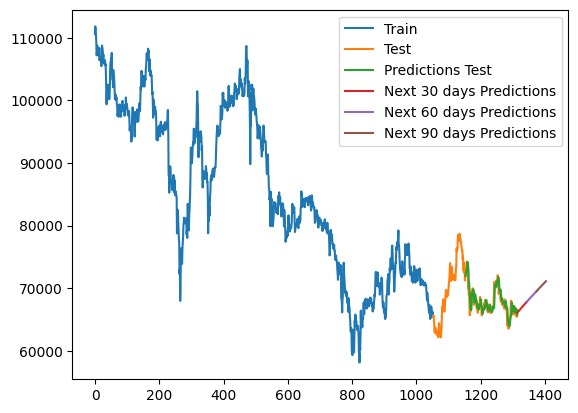

In [36]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + time_step + 1 , stop=len(df1), step=1)
plt.plot(test_data_index, y_pred)

next_30_days_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1) + 29, stop=len(df1) + 59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1) + 59, stop=len(df1) + 89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train', 'Test', 'Predictions Test', 'Next 30 days Predictions', 'Next 60 days Predictions', 'Next 90 days Predictions'])
plt.show()

<h1># Split the data into training, testing arcording to 9:1

In [51]:
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

In [52]:
train_data = df1[:train_size]
test_data = df1[train_size:]

<h1> Create dataset

In [53]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [54]:
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [55]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [56]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [57]:
#Fit the model
model.fit(X_train,y_train,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 5s 73ms/step - loss: 0.0550
Epoch 2/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0088
Epoch 3/100
17/17 [==============================] - 1s 62ms/step - loss: 0.0044
Epoch 4/100
17/17 [==============================] - 1s 84ms/step - loss: 0.0021
Epoch 5/100
17/17 [==============================] - 2s 102ms/step - loss: 0.0013
Epoch 6/100
17/17 [==============================] - 2s 102ms/step - loss: 0.0010
Epoch 7/100
17/17 [==============================] - 1s 68ms/step - loss: 9.5636e-04
Epoch 8/100
17/17 [==============================] - 1s 61ms/step - loss: 9.3506e-04
Epoch 9/100
17/17 [==============================] - 1s 60ms/step - loss: 9.1312e-04
Epoch 10/100
17/17 [==============================] - 1s 61ms/step - loss: 8.9078e-04
Epoch 11/100
17/17 [==============================] - 1s 62ms/step - loss: 8.8068e-04
Epoch 12/100
17/17 [==============================] - 1s 60ms/step - loss: 8.6285e-04

<h1>Du bao du lieu test

In [58]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 36ms/step


In [59]:
#Chuan hoa du lieu cua y_pred
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)

In [60]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[64000.],
       [64200.],
       [64200.],
       [64000.],
       [63500.],
       [64000.],
       [64700.],
       [65000.],
       [65400.],
       [65600.],
       [65800.],
       [68000.],
       [67900.],
       [66600.],
       [66500.],
       [65800.],
       [66500.],
       [67000.],
       [67200.],
       [67000.],
       [66400.],
       [66200.],
       [65800.],
       [67000.],
       [66000.],
       [66100.],
       [66800.],
       [66300.],
       [65700.],
       [65400.],
       [66100.]])

<h1>Evaluate the accuracy of the algorithm

In [61]:
#Tính RMSE, MAE, MAPE
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Testing RMSE:', test_rmse)

#MAE
test_mae = mean_absolute_error(ytest, y_pred)
print('Testing MAE:', test_mae)

#MAPE
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Testing MAPE:', test_mape)

Testing RMSE: 737.1042575994132
Testing MAE: 601.2032510080645
Testing MAPE: 0.911639392292378


<h1>Du doan co phieu trong 30, 60, 90 ngay tiep theo

In [62]:
x_input=test_data[-time_step:].reshape(1,-1)
x_input.shape
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<90):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.14954351]
101
1 day input [0.18257135 0.17154416 0.16970474 0.15867756 0.16602964 0.15316303
 0.14948792 0.15684    0.15132548 0.15684    0.16786719 0.17338171
 0.16235267 0.15500059 0.14765037 0.14948792 0.14948792 0.14765037
 0.14948792 0.15867756 0.15684    0.16786719 0.16051511 0.16051511
 0.16051511 0.20462758 0.23954856 0.23219648 0.22852137 0.2340359
 0.22300685 0.22300685 0.24138612 0.24506309 0.24138612 0.23219648
 0.24138612 0.25976724 0.23771101 0.24138612 0.20462758 0.21014211
 0.20462758 0.21933174 0.21381722 0.19892316 0.18216735 0.18030559
 0.1840291  0.19147613 0.18030559 0.1709968  0.17844383 0.17844383
 0.17844383 0.17658207 0.16541153 0.1709968  0.15982626 0.18775262
 0.18216735 0.16541153 0.16541153 0.16168802 0.1579645  0.15982626
 0.12631463 0.10955882 0.11328233 0.11328233 0.10955882 0.10025003
 0.10955882 0.12259112 0.12817639 0.13562342 0.13934693 0.14307045
 0.1840291  0.18216735 0.1579645  0.15610275 0.14307045 0.15610275
 0.16541153 0.16913505 0.16541153 

In [63]:
print(scaler.inverse_transform(lst_output))

[[66147.68562981]
 [66260.0231894 ]
 [66372.29831922]
 [66483.66581631]
 [66594.27135011]
 [66704.2381794 ]
 [66813.64874347]
 [66922.55986943]
 [67031.02358207]
 [67139.0702959 ]
 [67246.72802426]
 [67354.01597633]
 [67460.94695821]
 [67567.53057447]
 [67673.77642969]
 [67779.68452388]
 [67885.26366123]
 [67990.50983983]
 [68095.42866236]
 [68200.01932844]
 [68304.28503958]
 [68408.2257958 ]
 [68511.83759517]
 [68615.12283885]
 [68718.0879299 ]
 [68820.72966677]
 [68923.05125101]
 [69025.05108184]
 [69126.73316117]
 [69228.0982894 ]
 [69329.14886765]
 [69429.88889784]
 [69530.31597883]
 [69630.43411251]
 [69730.25050234]
 [69829.75714448]
 [69928.96524429]
 [70027.87480176]
 [70126.48901842]
 [70224.80949503]
 [70322.83943313]
 [70420.58043346]
 [70518.03889909]
 [70615.21322925]
 [70712.10902661]
 [70808.72789194]
 [70905.07462752]
 [71001.14923337]
 [71096.95651175]
 [71192.49726306]
 [71287.77628959]
 [71382.79679286]
 [71477.5579725 ]
 [71572.06783231]
 [71666.32397115]
 [71760.32

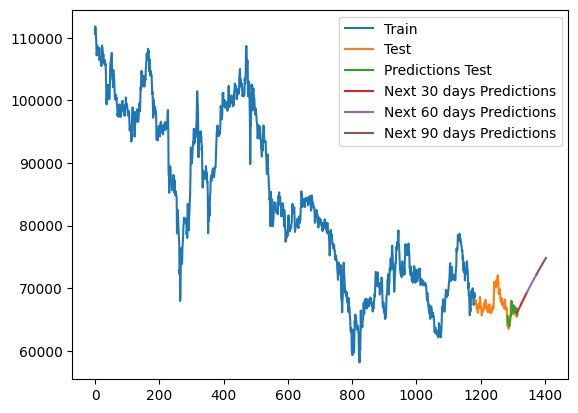

In [64]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=len(df1), step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size + time_step + 1 , stop=len(df1), step=1)
plt.plot(test_data_index, y_pred)

next_30_days_index = pd.RangeIndex(start=len(df1) - 1, stop=len(df1) + 29, step=1)
plt.plot(next_30_days_index, scaler.inverse_transform(lst_output[:30]))

next_60_days_index = pd.RangeIndex(start=len(df1) + 29, stop=len(df1) + 59, step=1)
plt.plot(next_60_days_index, scaler.inverse_transform(lst_output[30:60]))

next_90_days_index = pd.RangeIndex(start=len(df1) + 59, stop=len(df1) + 89, step=1)
plt.plot(next_90_days_index, scaler.inverse_transform(lst_output[60:]))

plt.legend(['Train', 'Test', 'Predictions Test', 'Next 30 days Predictions', 'Next 60 days Predictions', 'Next 90 days Predictions'])
plt.show()